## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
original_data.sample(5)

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
73585,Adoption,Spayed Female,0.164384,Cat,Normal,Stray,Intact Female,0.164384,2017,1.0,5.170833
61028,Adoption,Neutered Male,7.000000,Dog,Normal,Stray,Neutered Male,7.000000,2016,1.0,30.640278
61432,Adoption,Neutered Male,0.082192,Dog,Normal,Stray,Intact Male,0.010959,2017,1.0,53.027778
26181,Return to Owner,Spayed Female,4.000000,Dog,Normal,Public Assist,Spayed Female,4.000000,2014,1.0,6.049306
47816,Return to Owner,Spayed Female,2.000000,Dog,Normal,Stray,Intact Female,2.000000,2016,1.0,10.078472


In [4]:
original_data['outcome_type'].value_counts()

Adoption           33594
Transfer           23799
Return to Owner    14791
Euthanasia          6244
Died                 690
Disposal             304
Rto-Adopt            179
Missing               46
Relocate              15
Name: outcome_type, dtype: int64

In [5]:
original_data.loc[original_data['outcome_type'] != 'Adoption', "outcome_type"] = 0
original_data.loc[original_data['outcome_type'] == 'Adoption', "outcome_type"] = 1


In [6]:
original_data.sample(5)

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
56135,1,Intact Female,0.657534,Other,Normal,Public Assist,Intact Female,0.657534,2016,1.0,14.943750
55312,0,Spayed Female,1.000000,Dog,Normal,Stray,Intact Female,1.000000,2016,1.0,4.270833
42964,1,Spayed Female,0.164384,Dog,Normal,Stray,Intact Female,0.082192,2015,2.0,5.250694
5708,1,Neutered Male,0.164384,Dog,Normal,Stray,Intact Male,0.082192,2013,1.0,4.995833
39955,0,Neutered Male,3.000000,Cat,Normal,Stray,Neutered Male,3.000000,2015,1.0,2.268750


In [7]:
original_data.isna().sum()

outcome_type                0
sex_upon_outcome            1
age_upon_outcome_(years)    0
animal_type                 0
intake_condition            0
intake_type                 0
sex_upon_intake             1
age_upon_intake_(years)     0
intake_year                 0
intake_number               0
time_in_shelter_days        0
dtype: int64

In [8]:
print(f"old data shape: {original_data.shape}")
original_data.dropna(inplace=True)
print(f"new data shape: {original_data.shape}")

old data shape: (79672, 11)
new data shape: (79671, 11)


In [9]:
def split_data_ratio(df, ratio=0.2):
    new_df = df.copy()
    indicies = np.random.permutation(new_df.index)
    test_size = int(len(new_df)*ratio)

    test_df = new_df.loc[indicies[:test_size]]
    train_df = new_df.loc[indicies[test_size:]]

    return train_df, test_df

In [10]:
def standardise(df):
    new_df = df.copy()
    for col in new_df.columns:
        if new_df[col].dtype == np.float64:
            new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
    return new_df

In [11]:
standardised_data = standardise(original_data)


In [12]:
dummy_var_df = pd.get_dummies(standardised_data, columns = ['sex_upon_outcome', "animal_type", "intake_condition", "intake_type", "sex_upon_intake"], \
               prefix=['S_out', "animal_type", "intake_condition", "intake_type", "S_in"])


In [16]:
pd.set_option('display.max_columns', None)
dummy_var_df.head()


,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,S_out_Intact Female,S_out_Intact Male,S_out_Neutered Male,S_out_Spayed Female,S_out_Unknown,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,S_in_Intact Female,S_in_Intact Male,S_in_Neutered Male,S_in_Spayed Female,S_in_Unknown
0,0,2.709430,2.727926,2017,-0.278081,-0.387936,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0,1.674963,1.690991,2014,1.914615,-0.371824,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,1.330141,1.345346,2014,4.107310,-0.375323,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,2.709430,2.727926,2014,-0.278081,-0.282802,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,4.778363,4.801796,2013,-0.278081,-0.399182,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


Dans la correction ils ont normalisé le one hot encoding, wtf ? Et j'ai une colonne en plus..

In [17]:
dummy_var_df.shape

(79671, 33)

In [18]:
df_train, df_test = split_data_ratio(dummy_var_df)

### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [19]:
y = df_train['outcome_type']
X = df_train.drop(columns=['outcome_type'])

In [20]:
y.to_numpy().astype(int)

array([0, 1, 0, ..., 1, 0, 1])

In [21]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)

In [22]:
trained = logistic.fit(X, y.astype(int))

In [23]:
y_pred_test = logistic.predict(df_test.drop(columns=['outcome_type']))

In [24]:
confusion_matrix = pd.crosstab(df_test['outcome_type'], y_pred_test, rownames=['Actual'], colnames=['Predicted'])

In [25]:
print(confusion_matrix)

Predicted     0     1
Actual               
0          7513  1631
1          1248  5542


In [26]:
def calculate_metrics(confusion_matrix):
    accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix.sum().sum()
    presicion = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[0][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])
    f1 = 2 * (presicion * recall) / (presicion + recall)

    return accuracy, presicion, recall, f1

In [27]:
accuracy, presicion, recall, f1 = calculate_metrics(confusion_matrix)
print(f"accuracy: {accuracy}")
print(f"presicion: {presicion}")
print(f"recall: {recall}")
print(f"f1: {f1}")

accuracy: 0.8193171833814484
presicion: 0.81620029455081
recall: 0.7726195455179145
f1: 0.7938122180047269


On est vrm pas loin des résultats de la correction donc isok 

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [100]:
thresholds = np.arange(1, 10)/10
accuracies, presicions, recalls, f1s = [], [], [], []
for i in thresholds:
    y_pred_test = (logistic.predict_proba(df_test.drop(columns=['outcome_type']))[:,1] > i).astype(int)
    confusion_matrix = pd.crosstab(df_test['outcome_type'], y_pred_test, rownames=['Actual'], colnames=['Predicted'])
    accuracy, presicion, recall, f1 = calculate_metrics(confusion_matrix)
    print(f"For threshold {i}, accuracy: {accuracy}, presicion: {presicion}, recall: {recall}, f1: {f1}")
    accuracies.append(accuracy)
    presicions.append(presicion)
    recalls.append(recall)
    f1s.append(f1)


For threshold 0.1, accuracy: 0.7115601857662859, presicion: 0.9807578448786264, recall: 0.5973674720519293, f1: 0.7424921559838639
For threshold 0.2, accuracy: 0.7635245387222291, presicion: 0.9533747779751333, recall: 0.6510006064281383, f1: 0.7736936936936938
For threshold 0.3, accuracy: 0.7890674030375298, presicion: 0.9261397276494967, recall: 0.686149797126878, f1: 0.7882834645669291
For threshold 0.4, accuracy: 0.8200702899460274, presicion: 0.86101243339254, recall: 0.7510652033570046, f1: 0.8022894972760499
For threshold 0.5, accuracy: 0.81379440190787, presicion: 0.7886323268206039, recall: 0.7758846657929227, f1: 0.7822065624311826
For threshold 0.6, accuracy: 0.8003640015062131, presicion: 0.7251332149200711, recall: 0.7872408806042102, f1: 0.7549117805686109
For threshold 0.7, accuracy: 0.7884398142337141, presicion: 0.6489046773238603, recall: 0.8144157532974178, f1: 0.7223000247137326
For threshold 0.8, accuracy: 0.6945525291828794, presicion: 0.32978093546477205, recall:

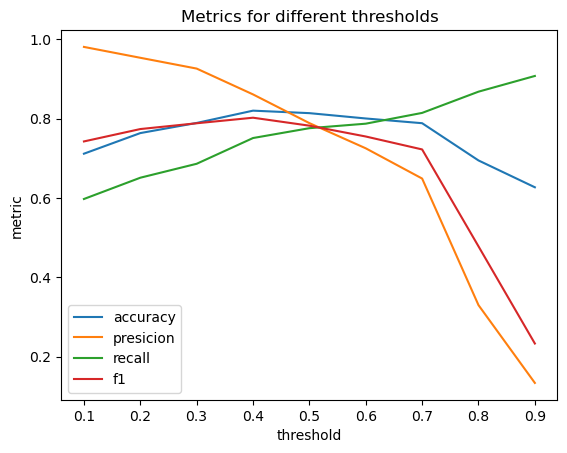

In [105]:
plt.plot(thresholds, accuracies, label='accuracy')
plt.plot(thresholds, presicions, label='presicion')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='f1')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.title('Metrics for different thresholds')
plt.legend()
plt.show()

Enft il fallait calculer les negative and positive precision, recall etc... c'est sûrememt pour ça que j'ai pas les mêmes courbes, moi j'ai que les positive, en vrai ça devrai être les mêmes, je comprends pas 


### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

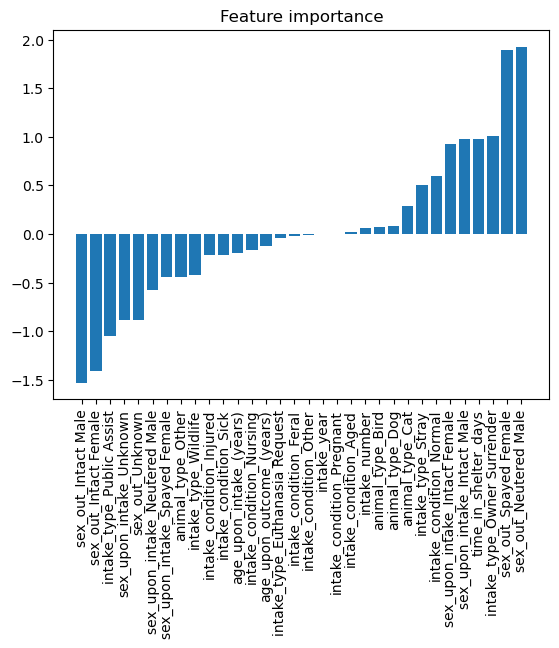

In [110]:
indicies = np.argsort(logistic.coef_[0])
plt.bar(X.columns[indicies], logistic.coef_[0][indicies], )
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.show()


In [28]:
### Correction !!
tmp = []
for name, value in zip(X.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
6,S_out_Intact Male,-1.608078
5,S_out_Intact Female,-1.460968
24,intake_type_Public Assist,-1.166745
31,S_in_Unknown,-0.907848
9,S_out_Unknown,-0.907848


<BarContainer object of 32 artists>

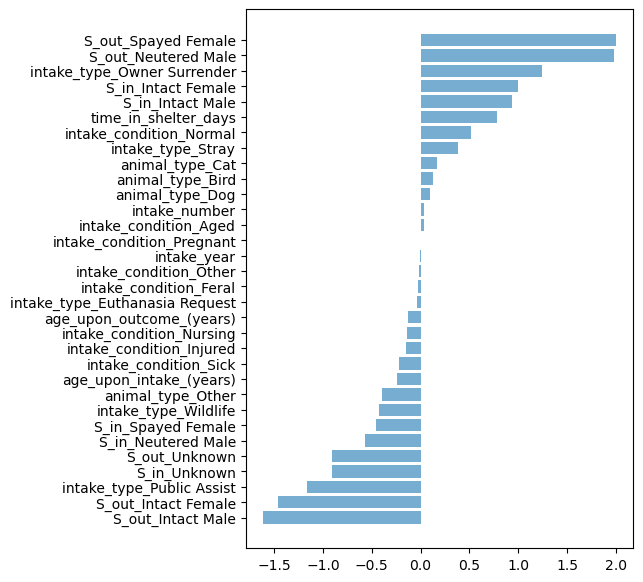

In [29]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

J'ai bizarrement pas du tout la même chose que eux sur les trucs important ou non, surtout sur les ages of intake and outake. Flemme de corriger plus en approfondie, je sais pas is c'est mon preprocessing ou le training ou les deux. Mais j'ai pas le temps de mettre plus de temps là dedans..



## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

a)

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [113]:
(50+100) / 165

0.9090909090909091

In [120]:
false_positive_rate = 10 / 60
print(false_positive_rate)

0.16666666666666666


In [119]:
true_positive_rate = 100 / 105
print(true_positive_rate)

0.9523809523809523


d) is the answer